# Bank Customer Churn


## Data Background

This dataset can be found [here](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset) on kaggle.com.  It appears to be fictitious data created for a ML classification exercise

## Data Dictionary


* **customer_id** - unused variable.
* **credit_score** - 
* **country** - 
* **gender** - 'Male' or 'Female'
* **age** - 
* **tenure** - assuming years with as customer
* **balance** - 
* **products_number** - assuming number of bank products used (e.g. credit, home loan, checking acct., etc.)
* **credit_card** - 1 or 0
* **active_member** - 1 or 0
* **estimated_salary** - 
* **churn** - used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

## Imports

In [44]:
# Analysis, Visualization
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
# DBMS
import duckdb
# ML
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV)
# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             classification_report, ConfusionMatrixDisplay)
# Settings
pd.set_option('display.float_format', '{:.2f}'.format)

## Database Creation, Loading Data

In [2]:
# creating connection to database
conn = duckdb.connect('churn_data.db')

In [3]:
# creating a df frame
df = conn.execute('''
from 'Bank Customer Churn Prediction.csv'
''').df()

## Viewing Data

In [4]:
df.sample(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
6748,15637646,756,France,Male,31,10,122647.32,1,0,0,61666.87,0
2413,15604073,815,Germany,Female,25,8,135161.67,1,1,1,136071.05,0
8360,15754747,686,Germany,Male,33,9,141918.09,2,0,1,184036.47,0
705,15580148,750,Germany,Male,40,5,168286.81,3,1,0,20451.99,1
127,15782688,625,Germany,Male,56,0,148507.24,1,1,0,46824.08,1


In [5]:
display(df.describe(include='all').T, df.info(), df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000.00,NaN,NaN,NaN,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
credit_score,10000.00,NaN,NaN,NaN,650.53,96.65,350.00,584.00,652.00,718.00,850.00
country,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,10000.00,NaN,NaN,NaN,38.92,10.49,18.00,32.00,37.00,44.00,92.00
tenure,10000.00,NaN,NaN,NaN,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,10000.00,NaN,NaN,NaN,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
products_number,10000.00,NaN,NaN,NaN,1.53,0.58,1.00,1.00,1.00,2.00,4.00
credit_card,10000.00,NaN,NaN,NaN,0.71,0.46,0.00,0.00,1.00,1.00,1.00
active_member,10000.00,NaN,NaN,NaN,0.52,0.50,0.00,0.00,1.00,1.00,1.00


None

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

<mark><u>**Comment:**</u>

* <font color='dodgerblue' size=4><i>
    Overall this data looks pretty clean, we will still check for duplicates and NaNs, but it appears to have been pre-cleaned.
* <font color='dodgerblue' size=4><i>
    We should be able to discard customer id, but will check to make sure there are no duplicate values (customer entered in twice).
* <font color='dodgerblue' size=4><i>
    There are only 3 countries in the dataset, with France being the most frequent.  We'll have to keep this in mind when thinking of the scope of the model's usability
* <font color='dodgerblue' size=4><i>
    Most of our values are already ordinal/ohe encoded, but will have to adjust the 'gender' column.
    
</i></font>

## Cleaning

### checking for duplicates, NaNs

In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [8]:
# checking customer id column to see if there are repeated values
df['customer_id'].value_counts().max()

1

### changing 'gender' to numerical, 1=male, 0=female

In [9]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# confirming
df['gender'].value_counts()

gender
1    5457
0    4543
Name: count, dtype: int64

### checking categorical values for errors

In [10]:
for i in df.columns:
    if df[i].dtype == 'object' or df[i].nunique() <= 10:
        print(i.upper(), '\n', df[i].unique(), df[i].dtype)

COUNTRY 
 ['France' 'Spain' 'Germany'] object
GENDER 
 [0 1] int64
PRODUCTS_NUMBER 
 [1 3 2 4] int64
CREDIT_CARD 
 [1 0] int64
ACTIVE_MEMBER 
 [1 0] int64
CHURN 
 [1 0] int64


<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
All looks good!
</i></font>

### rechecking dtypes

In [11]:
df.dtypes

customer_id           int64
credit_score          int64
country              object
gender                int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

### dropping 'customer_id' column

In [12]:
df = df.drop(columns='customer_id').copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  int64  
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 859.5+ KB


## EDA

### Brief Overview of data visualized

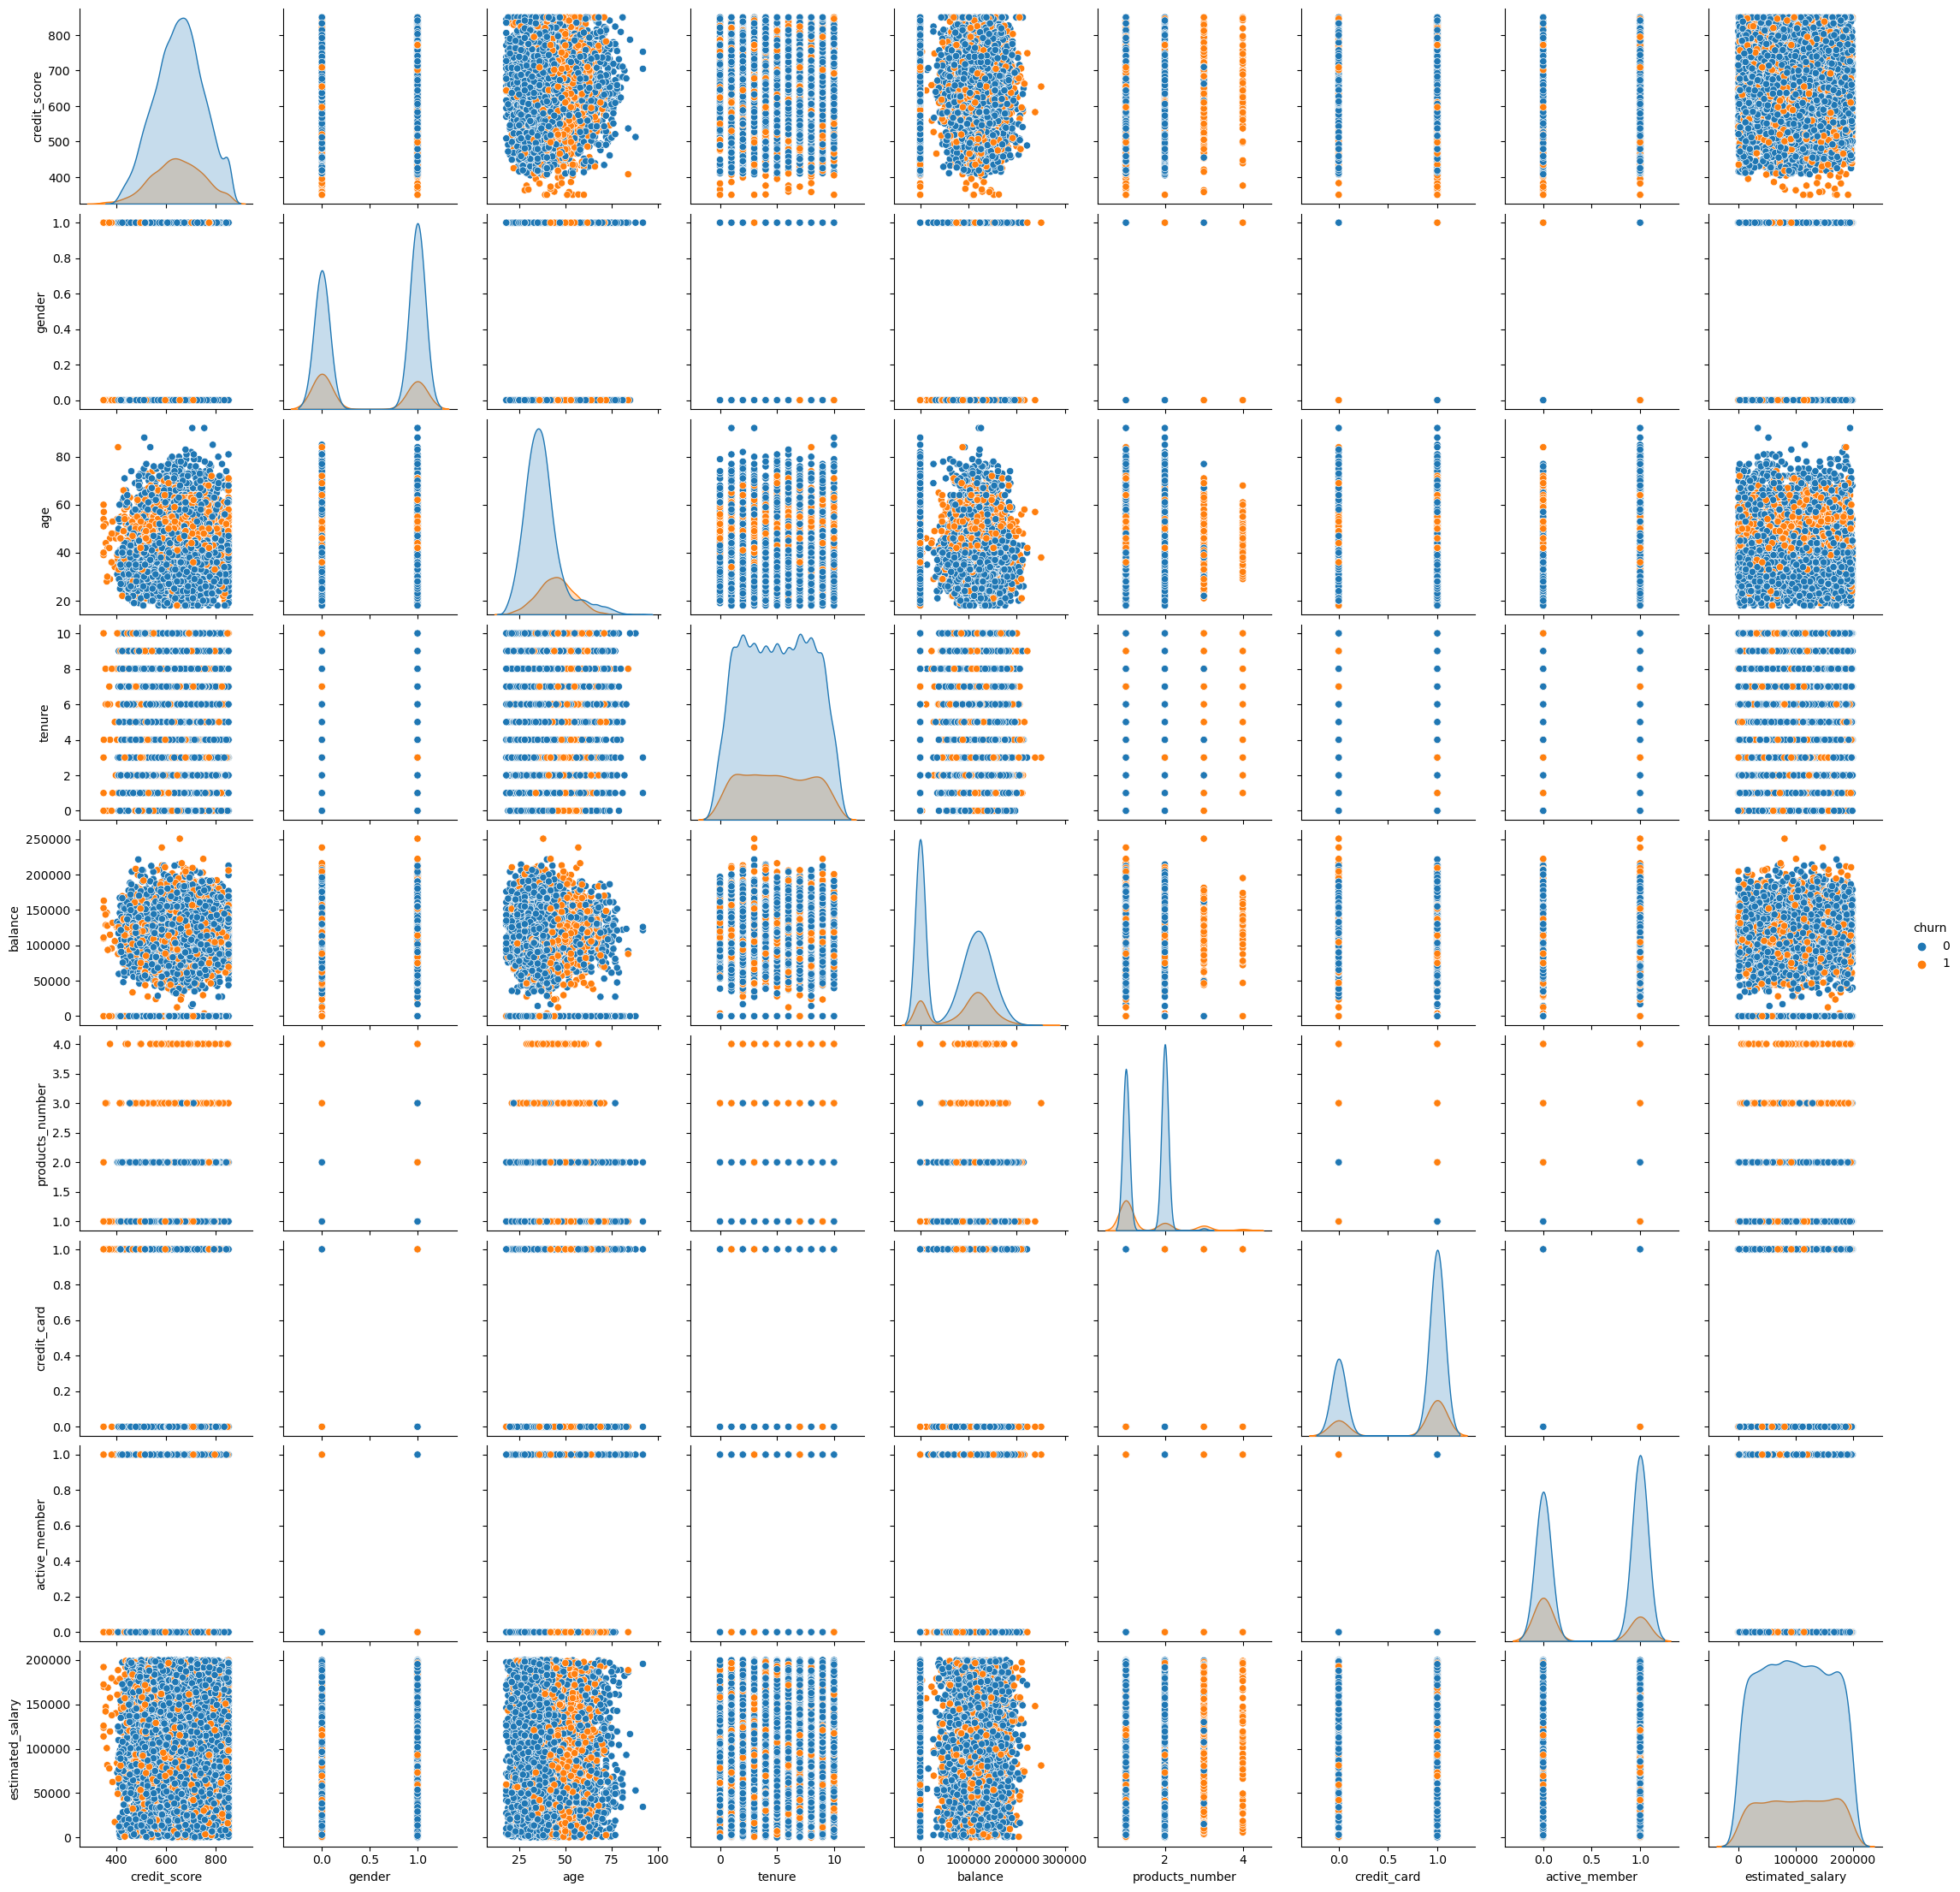

In [13]:
sns.pairplot(data=df, hue='churn');

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
It appears there are features in this dataset which should help the models differentiate churned customers.  'age', 'estimated salary', and 'number of products' seem to be the most likely candidates.  There is an interesting band of churned customers between ages 45-75 that I'd like to explore.
</i></font>

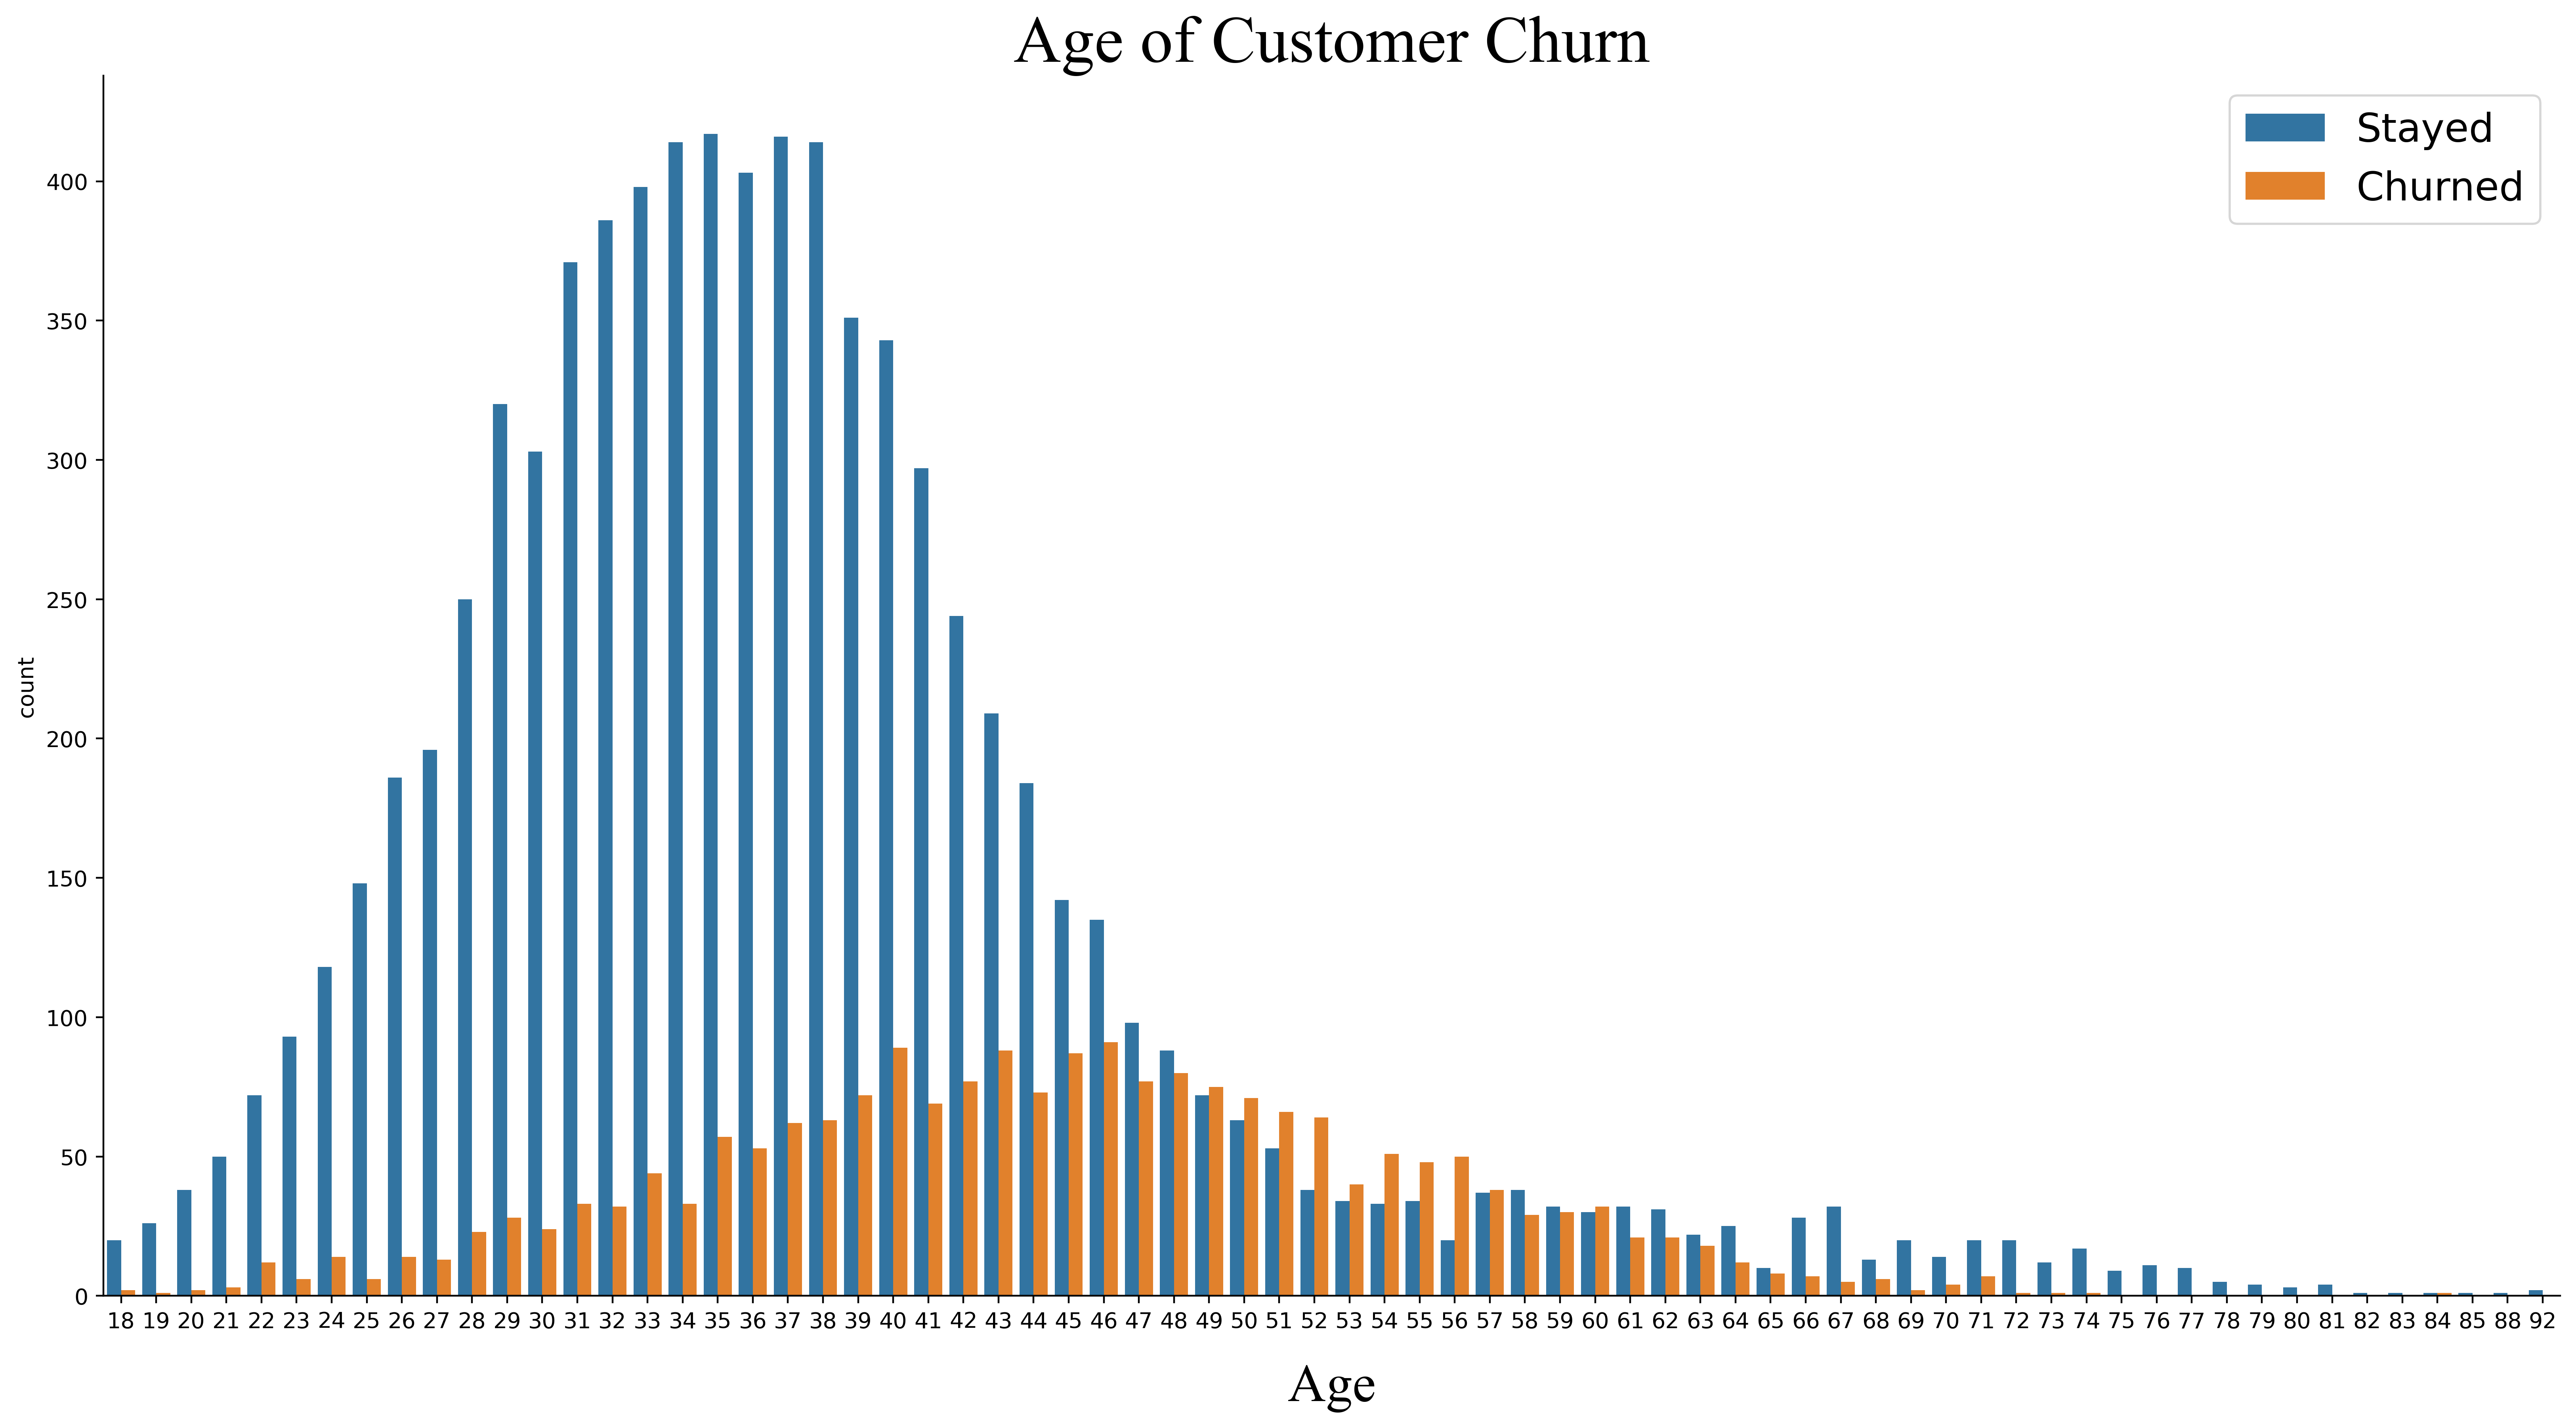

In [14]:
# exploring age of churn
plt.figure(figsize=(20,10), dpi=400)
ax = plt.gca()
sns.countplot(data=df, x='age', hue='churn')
plt.title('Age of Customer Churn', font={'size':30, 'family':'Times New Roman'})
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('Age', fontsize=24, labelpad=14, fontfamily='Times New Roman')
plt.legend(labels= ['Stayed', 'Churned'], fontsize=18);

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Here's what I would speculate is going on here:  As customers accrue more wealth going in to middle age, they have more capital to use and various financial products become more relevant to them.  This results in seeking more competitive offers on financial instruments, increasing their likelihood of churning.  In their 20's and early 30's, they're more likely to have little capital to work with, so they may be more likely to keep the same bank, only utilizing savings/checking options.
</i></font>

## Splitting Features and Target, Train/Test

### Train Test Split

In [15]:
# checking balance on our target
df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
We will stratify our split since we have an unbalanced target
</i></font>

In [16]:
X = df.drop(columns='churn').copy()
y = df['churn'].copy()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# confirming
print(df.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10000, 11) (7500, 10) (2500, 10) (7500,) (2500,)


## Preprocesser

In [18]:
# another look at data types
X.dtypes

credit_score          int64
country              object
gender                int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
dtype: object

In [19]:
## unused code for automating if feature inputs change, will specify columns
##    because some are already ordinal encoded
# cat_selector = make_column_selector(dtype_include='object')
# num_selector = make_column_selector(dtype_include='number')

cat_columns = ['country']
# these are columns that need to be scaled
num_columns = ['credit_score', 'age', 'balance', 'estimated_salary']

cat_preprocessor = OneHotEncoder(sparse=False, handle_unknown='ignore')
num_preprocessor = StandardScaler()

In [20]:
preprocessor = ColumnTransformer(
    [('cat_processor', cat_preprocessor, cat_columns),
     ('num_processor', num_preprocessor, num_columns)
    ],
    remainder='passthrough'
    )
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_processor',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['country']),
                                ('num_processor', StandardScaler(),
                                 ['credit_score', 'age', 'balance',
                                  'estimated_salary'])])

In [21]:
# confirming that the preprocessor is working as expected
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_train_proc_df = pd.DataFrame(X_train_proc)
X_train_proc_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,0.50,0.25,0.25,-0.00,0.00,-0.00,-0.00,0.55,5.02,1.53,0.71,0.52
std,0.50,0.43,0.43,1.00,1.00,1.00,1.00,0.50,2.89,0.58,0.46,0.50
min,0.00,0.00,0.00,-3.11,-1.99,-1.22,-1.74,0.00,0.00,1.00,0.00,0.00
25%,0.00,0.00,0.00,-0.69,-0.66,-1.22,-0.86,0.00,3.00,1.00,0.00,0.00
50%,0.00,0.00,0.00,0.02,-0.19,0.33,-0.01,1.00,5.00,1.00,1.00,1.00
75%,1.00,0.00,1.00,0.69,0.48,0.82,0.85,1.00,8.00,2.00,1.00,1.00
max,1.00,1.00,1.00,2.06,5.03,2.34,1.75,1.00,10.00,4.00,1.00,1.00


<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Looks good, our numerical columns have been scaled, while our ordinal and binary columns have stayed intact.  Plus we have added the 2 extra columns expected due to One Hot Encoding the 'country' column (3 values for 'country')
</i></font>

## Random Forest Model

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
For this particular application, it seems appropriate to **strive for a high recall score** (i.e. we want to catch all customers at high risk of leaving).<br><br>
The assumption baked into this approach is that the costs of a leaving customer are higher than the cost of attempting to retain a customer at risk of churning.
</i></font>

### Base Model

#### Building Model

In [22]:
# building the model pipeline
ranfor_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('Random Forest Classifier', RandomForestClassifier(random_state=42))
    ]
)
ranfor_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_processor',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country']),
                                                 ('num_processor',
                                                  StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'balance',
                                                   'estimated_salary'])])),
                ('Random Forest Classifier',
                 RandomForestClassifier(random_state=42))])

In [23]:
ranfor_pipe.fit(X_train, y_train)

ranfor_pipe.score(X_test, y_test)

0.8648

In [24]:
# Showing that the default 'score' is indeed the accuracy score
accuracy_score(y_test, ranfor_pipe.predict(X_test))

0.8648

In [42]:
# Showing that the default 'score' is indeed the accuracy score
recall_score(y_test, ranfor_pipe.predict(X_test))

0.4675834970530452

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Yikes, this is a terrible recall score (.47).  The accuracy score is decent (.87).  I think this is the result of many more customers that have not churned, and a wide overlap between the two groups.  So the model captures non-churning customers well, and thus elevates the accuracy score.  We'll attempt to improve it through RandomizedSearchCV, but we may have to feature engineer our way to a better dataset, or reframe the possibilities of the model
</i></font>

### Dummy Classifier

In [46]:
dumb_class_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('dumb classifier', DummyClassifier(strategy='most_frequent'))
    ]
)
dumb_class_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_processor',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country']),
                                                 ('num_processor',
                                                  StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'balance',
                                                   'estimated_salary'])])),
                ('dumb classifier', DummyClassifier(strategy='most_frequent'))])

In [50]:
display(
    f'Dummy Accuracy: {accuracy_score(y_test, dumb_class_pipe.predict(X_test))}',
    f'Dummy Recall: {recall_score(y_test, dumb_class_pipe.predict(X_test))}',
                                     
)

'Dummy Accuracy: 0.7964'

'Dummy Recall: 0.0'

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Okay, so at least our base model outperforms a dummy classifier
</i></font>

### Randomized Search CV

In [25]:
# getting hyperparameters to tune
ranfor_pipe.get_params();

In [32]:
# these results have been iteratively narrowed in scope to hone in on best model
ranfor_params = {
    'Random Forest Classifier__max_depth': range(15, 28),
    'Random Forest Classifier__max_leaf_nodes': range(80, 141, 2),
    'Random Forest Classifier__n_estimators': range(480, 601, 10)
}

In [38]:
ranfor_random = RandomizedSearchCV(ranfor_pipe, ranfor_params, n_iter=60,
                                  random_state=42, scoring='recall')
ranfor_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_processor',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['country']),
                                                                              ('num_processor',
                                                                               StandardScaler(),
                                                                               ['credit_score',
                                                                                'age',
                                                                                'balance',
                                                                                'estimated_salary'])])),
                                             ('Random Forest Classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=60,
                   param_distributions={'Random Forest Classifier__max_depth': range(15, 28),
                                        'Random Forest Classifier__max_leaf_nodes': range(80, 141, 2),
                                        'Random Forest Classifier__n_estimators': range(480, 601, 10)},
                   random_state=42, scoring='recall')

In [39]:
ranfor_df = pd.DataFrame(ranfor_random.cv_results_)

In [40]:
ranfor_df.sort_values('rank_test_score').T

,3,57,49,54,9,8,50,59,1,27,...,56,36,7,23,5,31,43,34,18,37
mean_fit_time,1.28,1.30,1.38,1.40,1.60,1.42,1.42,1.29,1.29,1.29,...,1.23,1.32,1.43,1.43,1.37,1.28,1.45,1.26,1.35,1.47
std_fit_time,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.02,0.01,...,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.03,0.01,0.01
mean_score_time,0.05,0.05,0.06,0.06,0.06,0.06,0.06,0.05,0.05,0.05,...,0.05,0.05,0.06,0.06,0.05,0.05,0.06,0.05,0.05,0.07
std_score_time,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03
param_Random Forest Classifier__n_estimators,480,490,520,530,600,540,540,490,490,500,...,490,540,580,580,560,520,590,500,550,600
param_Random Forest Classifier__max_leaf_nodes,140,140,138,134,140,128,128,134,124,114,...,92,80,82,82,80,80,82,84,80,80
param_Random Forest Classifier__max_depth,26,27,25,23,18,26,24,17,25,17,...,15,25,15,16,15,17,22,26,26,27
params,{'Random Forest Classifier__n_estimators': 480...,{'Random Forest Classifier__n_estimators': 490...,{'Random Forest Classifier__n_estimators': 520...,{'Random Forest Classifier__n_estimators': 530...,{'Random Forest Classifier__n_estimators': 600...,{'Random Forest Classifier__n_estimators': 540...,{'Random Forest Classifier__n_estimators': 540...,{'Random Forest Classifier__n_estimators': 490...,{'Random Forest Classifier__n_estimators': 490...,{'Random Forest Classifier__n_estimators': 500...,...,{'Random Forest Classifier__n_estimators': 490...,{'Random Forest Classifier__n_estimators': 540...,{'Random Forest Classifier__n_estimators': 580...,{'Random Forest Classifier__n_estimators': 580...,{'Random Forest Classifier__n_estimators': 560...,{'Random Forest Classifier__n_estimators': 520...,{'Random Forest Classifier__n_estimators': 590...,{'Random Forest Classifier__n_estimators': 500...,{'Random Forest Classifier__n_estimators': 550...,{'Random Forest Classifier__n_estimators': 600...
split0_test_score,0.42,0.42,0.43,0.42,0.43,0.42,0.42,0.43,0.42,0.42,...,0.41,0.42,0.42,0.42,0.41,0.41,0.42,0.41,0.41,0.41
split1_test_score,0.37,0.37,0.37,0.38,0.37,0.38,0.38,0.38,0.37,0.37,...,0.37,0.36,0.37,0.37,0.37,0.36,0.36,0.36,0.36,0.36


In [41]:
plt.figure(figsize=(10,10), dpi=300)
fig = px.parallel_coordinates(
    ranfor_df.rename(columns=lambda x: x.split('__')[1] if '__' in x else x).apply(
                {'max_depth':lambda x:x,
               'max_leaf_nodes':lambda x:x,    
               'n_estimators':lambda x:x,
                'mean_test_score':lambda x: x}),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis
)

# Show the plot
fig.show();

<Figure size 3000x3000 with 0 Axes>

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
This model seems to perform best when leaf nodes are higher and estimators are lower.
</i></font>

### Best Params on Test

In [52]:
recall_score(y_test, ranfor_random.best_estimator_.predict(X_test))

0.4381139489194499

## Feature Engineering

<font color='dodgerblue' size=4>
Before using different models to generalize the data, I'm going to see if we can increase model performance via feature engineering
</font>